# Chapter: Fully BNN (Bayesian Neural Network) Regression model
The goal of this chapter is to show how to define a fully Bayesian model for regression and how to train it using Kullback-Leibler divergence plus NLL loss in a vanilla Pytorch implementation. The idea behind a fully Bayesian NN model is the mixture between the Bayesian NN already introduced (with Bayesian layers trained using KL divergence) and the multi-head regression model based on NLL loss (i.e., variance attenuation loss for the Gaussian case).

In [1]:
# Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

path_pardir = Path(os.getcwd()).parent
path_data = os.path.join(path_pardir, 'Data')

## Data preparation and training/validation/test set preparation
This is an elementary implementation of a multi-head regression model in Pytorch using the Variance Attenuation Loss.

First we define the device (GPU/CPU) we are working with. Since we are working with simple numerical data, we choose the CPU to reduce the training time.

In [2]:
# Identify the existing device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Select cpu device
device = 'cpu'

The data frame is the linear relationship with homoscedastic aleatoric noise, we explicitly split the data frame into training/validation/test set.

In [3]:
chosen_df = "df_nonlinear_homoscedastic_aleatoric.csv"

full_df = pd.read_csv(os.path.join(path_data, chosen_df))

training_df = full_df[full_df["split_label"]==0]
validation_df = full_df[full_df["split_label"]==1]
test_df = full_df[full_df["split_label"]==2]

full_df.head(8)

,x_range,y_range,split_label
0,-100.00000,-1.827437,0
1,-99.89995,-2.038570,0
2,-99.79990,-2.156036,2
3,-99.69985,-1.881278,2
4,-99.59980,-2.062530,0
5,-99.49975,-1.886184,1
6,-99.39970,-1.834947,0
7,-99.29965,-1.823319,0


We define a CustomDataset from Pytorch Dataset. The dataset has an *init* (initialise the class), a *len* and a *getitem* method.
A Dataset must provide the tools to identify available data and return all the elements needed to train/test/evaluate the model.

Can be skipped if the data is particularly simple.

In [4]:
# Dataset definition:
class CustomDataset(Dataset):
    def __init__(self, annotations_file, path_data, split_label=None):
        if split_label!=None:
            self.df = pd.read_csv(os.path.join(path_data, annotations_file))
            self.df = self.df[self.df['split_label']==split_label]
        else:
            self.df = pd.read_csv(os.path.join(path_data, annotations_file))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x_range = float(self.df.iloc[idx]['x_range'])
        y_range = float(self.df.iloc[idx]['y_range'])

        features = torch.tensor([x_range], dtype=torch.float32)
        output = torch.tensor([y_range], dtype=torch.float32)
        
        return features, output

# Initialize Training dataset and show outputs and properties:
training_dataset = CustomDataset(annotations_file=chosen_df, path_data=path_data, split_label=0)
print("Length training dataset:", training_dataset.__len__())

index_example = 27
print(f"Output example (x_range,y_range)=({training_dataset.__getitem__(index_example)}) with index {index_example}.")

# Initialize validation and test datasets:
validation_dataset = CustomDataset(annotations_file=chosen_df, path_data=path_data, split_label=1)
test_dataset = CustomDataset(annotations_file=chosen_df, path_data=path_data, split_label=2)

Length training dataset: 1600
Output example (x_range,y_range)=((tensor([-96.3982]), tensor([-1.8095]))) with index 27.


To define a batch we can iterate on the whole dataset or define a *DataLoader* which samples from the introduced DataSet and can be iterated during training. It provides a batch of tensors to apply the computations efficiently at the same time.

In [5]:
# Size of each batch
batch_size = 15

# Define 3 DataLoaders: Training/Validation/Test 
training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Define a Bayesian Layer
To define a fully Bayesian model for regression we need to define a single (linear) Bayesian layer.

Each weight of the layer is made up of a *mu* (the mean) and a *log_sigma* (the logarithm of the standard deviation), which together give an output corresponding to a Gaussian distribution (fully characterised as $\mathcal{N}\left(\textit{mu}, \text{exp}\left( \textit{log\_sigma} \right) \right)$).
To ensure that the *sigma* is positive, the learnable value belongs to $\mathbb{R}$ and corresponds to the logarithmic value of the standard deviation. Therefore, in the inference phase, we have to apply an exponential to make it correspond to the real standard deviation.

The prior distribution of each distribution is introduced to update it using the KL divergence.

The biases are computed in the same way (as Gaussian distributions) with their own prior distribution.

The KL divergence is computed for the weights/biases of this layer and is added to all Bayesian layers to define the loss.

In [6]:
class LinearBayesianLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, prior_std=1.0):
        '''
        in_features: (int) number of input features
        out_features: (int) number of output features
        bias=Ture: (bool) add bias to mu and std
        prior_std: (float>0) standard deviation of prior distributions
        '''
        
        super().__init__()

        self.bias = bias

        # Learnable mean and log-standard_deviation
        # Define a (non-initialized) tensor with in_features to out_features dimensions
        self.mu = torch.empty(out_features, in_features)  
        # Random Gaussian initialization from values sampled from N(mean=0, std=0.1) 
        self.mu.normal_(0, 0.1)  
        # Make it a trainable parameter
        self.mu = nn.Parameter(self.mu)   

        # Initialize a trainable parameter with in_features to out_features to -5
        self.log_sigma = nn.Parameter(torch.Tensor(out_features, in_features).fill_(-5)) 

        # Fixed prior N(mean=0, std=prior_std) to compute KL divergence
        self.prior_mu = torch.zeros_like(self.mu)
        self.prior_sigma = torch.full_like(self.mu, prior_std)

        
        # The bias is another (distributional) trainable tensor
        if self.bias:
            # Initialize a learnable mean of bias
            self.mu_bias = nn.Parameter(torch.Tensor(out_features).normal_(0, 0.1))
        
            # Initialize a learnable std of bias
            self.log_sigma_bias = nn.Parameter(torch.Tensor(out_features).fill_(-5))

            # Fixed prior N(mean=0, std=prior_std) to compute bias KL divergence
            self.prior_mu_bias = torch.zeros_like(self.mu_bias)
            self.prior_sigma_bias = torch.full_like(self.mu_bias, prior_std)



    def forward(self, x, freezed = False):
        '''
        x: (tensor) input tensor
        freezed=False: (bool) if True, freeze all the std and make the network determistic
        
        RETURN: (w*x + bias)
        '''
        
        if freezed:
            # Define each weight as the average value self.mu
            weights = self.mu 

            if self.bias:
                # Define each bias as the average bias
                bias = self.mu_bias 
                
        else:
            # Sample weights using reparameterization trick: the weight is the N(mu, sigma) = mu + sigma*N(0,1)
            epsilon_w = torch.randn_like(self.mu)       # Random N(0,1) sampling
            sigma_w = torch.exp(self.log_sigma) + 1e-6  # Ensure positivity
            weights = self.mu + sigma_w * epsilon_w     # Sampled weights

            if self.bias:
                # Sample bias using reparameterization trick
                epsilon_b = torch.randn_like(self.mu_bias)       # Random N(0,1) sampling
                sigma_b = torch.exp(self.log_sigma_bias) + 1e-6  # Ensure positivity
                bias = self.mu_bias + sigma_b * epsilon_b        # Sampled bias

        if self.bias:    
            return F.linear(x, weights, bias)
        else:
            return F.linear(x, weights)

    
    
    def kl_divergence(self):
        '''
        Compute the KL divergence on each layer
        '''
        
        # Get the device of model parameters
        device = self.mu.device  

        # Set up the weights prior distribution as normal (prior_mu, prior_sigma)
        prior_w = torch.distributions.Normal(self.prior_mu.to(device), self.prior_sigma.to(device))
        
        # Set up the weights posterior distribution as normal (mu, sigma)
        posterior_w = torch.distributions.Normal(self.mu.to(device), torch.exp(self.log_sigma).to(device))
        
        # Compute KL divergence for the weights of this layer
        kl_w = torch.distributions.kl_divergence(posterior_w, prior_w).sum()  # KL for weights

        
        if self.bias:
            # Set up the prior bias distribution as normal (prior_mu_bias, prior_sigma_bias)
            prior_b = torch.distributions.Normal(self.prior_mu_bias.to(device), self.prior_sigma_bias.to(device))
            
            # Set up the posterior bias distribution as normal (mu_bias, sigma_bias)
            posterior_b = torch.distributions.Normal(self.mu_bias.to(device), torch.exp(self.log_sigma_bias).to(device))

        # Compute KL divergence for the bias of this layer
        kl_b = torch.distributions.kl_divergence(posterior_b, prior_b).sum()  # KL for bias

        if self.bias:
            return kl_w + kl_b  # Sum both KL divergences
        else:
            return kl_w

## Define a Bayesian model:
We can now introduce the model, following the structure of the corresponding deterministic counterpart, by replacing each deterministic linear layer with a Bayesian one.

The last layer outputs a mean and a standard deviation to approximate aleatoric uncertainty.

We defined additional module methods to compute the KL divergence as an average of the KL over the layers, a *MC_forward* method to derive statistics from multiple model runs, and a *Frozen_forward* method to compute a (deterministic) output given all weights frozen to their mean.

In [8]:
class FullyBayesianModelRegression(nn.Module):
    
    def __init__(self):    
        super().__init__()

        # We store all the bayesian layers in a list to compute efficiently the KL divergence
        self.bayesian_layers = nn.ModuleList([
            LinearBayesianLayer(1, 8),
            LinearBayesianLayer(8, 16),
            LinearBayesianLayer(16, 32),
            LinearBayesianLayer(32, 16),
            LinearBayesianLayer(16, 16)
        ])

        # Define the last layer as a mean and standard deviation:
        self.mean = nn.Linear(16, 1)  # Output the mean
        self.std = nn.Linear(16, 1)   # Output the std

        # Constant initialization of std to avoid too high values that stop gradient flow
        nn.init.constant_(self.std.weight, 0.1)
        nn.init.constant_(self.std.bias, 0.5)

    
    def forward(self, x, freezed = False):
        '''
        Define the sequential network by connecting LinearBayesianLayer with a ReLU activation function.

        x: (tensor) input tensor of the model
        freezed=False: (bool)

        RETURN: x (tensor) prediction
        '''
        
        for layer in self.bayesian_layers[:]:  
            x = layer(x, freezed)
            x = torch.relu(x)

        

        # Compute mean from the hidden layer:
        mean = self.mean(x)

        # Compute std from the hidden layer:
        std = self.std(x)
        std = torch.nn.functional.softplus(std) # Apply a softplus function to the std output to force a positive value
        std = torch.clamp(std, min=0.01, max=5) # Clamp the value between a minumum and a maximum (it should be adapted to the problem)
        
        return torch.cat([mean, std], dim=1)  # Return both mean and std
        

    
    def MC_forward(self, x, n_iter=1000):
        '''
        Monte Carlo forward iterations.

        To get the result of a BNN as a mean and a standard deviation, 
        we have to run the model several times and calculate statistics on the outputs.

        x: (tensor) input tensor of the model
        n_iter=1000: (int) number of iteratons to compute MC estimates

        RETURN: mean_predictions_mean, std_predictions_mean, mean_predictions_std (tuple of floats) 
        '''
        
        # Apply n_iter times the BNN model
        predictions = torch.stack([self.forward(x) for _ in range(n_iter)], dim=0)  # Shape: [n_iter, batch_size, output_dim]
        predictions_mean = predictions[:,0,0]
        predictions_std = predictions[:,0,1]

        # Compute mean over MC iterations mean predictions (this is the point estimate)
        mean_predictions_mean = predictions_mean.mean(dim=0)  

        # Compute standard deviation over MC iterations mean predictions (this is the epistemic uncertainty)
        std_predictions_mean = predictions_mean.std(dim=0)    

        # Compute mean over MC iterations std predictions (this is the point aleatoric uncertainty)
        mean_predictions_std = predictions_std.mean(dim=0)    
        
        # Return mean and std
        return mean_predictions_mean, std_predictions_mean, mean_predictions_std

    
    def Frozen_forward(self, x):
        '''
        Freeze all the stds of the BNN and compute the (deterministic) output considering the weights as deterministic 
        values fixed to the means.

        x: (tensor) input tensor of the model

        RETURN: x (tensor) prediction
        '''
        
        return self.forward(x, freezed = True)

    
    def kl_divergence(self):
        '''
        Average of the KL divergence of all Bayesian layers in the model.
        '''
        
        return sum(layer.kl_divergence() for layer in self.bayesian_layers)/ len(self.bayesian_layers)


# Initialize the model:
model = FullyBayesianModelRegression()

# Move the model to device (GPU):
model.to(device)

# Convert weights type to float:
model = model.float()

Introduce the loss and the optimiser. Both can be implemented explicitly. 

For BNNs computed using Variational Inference (VI), the loss is defined as the standard MSE (on the prediction) plus the KL divergence (multiplied by a beta term) averaged over all Bayesian layers. However, having a multi head neural network, standard MSE is substituted with Variance Attenuation Loss (i.e., NLL computed under Gaussian hypothesis)

In [9]:
# Extend Pytorch Module to define a "Variance Attenuation Loss" + KL divergence:
class VarianceAttenuationLossKL(nn.Module):
    def __init__(self, epsilon = 1e-6, set_to_zero = False):
        super(VarianceAttenuationLossKL, self).__init__()
        
        # To avoid division by 0 add a perturbatuion:
        self.epsilon = epsilon  

        # Boolean switch to decide to translate the NLL:
        self.set_to_zero = set_to_zero
        

    def forward(self, y_pred, y_true, kl_div = None, beta=1e-5):
        # Assuming y_pred has two outputs: mean and std:
        # Mean
        mean = y_pred[:, 0].unsqueeze(1)
        # Std
        variance = y_pred[:, 1].unsqueeze(1)**2 + self.epsilon # Add a perturbation 

        # Negative Log Likelihood
        nll = 0.5 * (torch.log(variance) + ((y_true - mean)**2)/variance)

        # Translate the minumum to zero
        if self.set_to_zero:
            nll = nll - 0.5*torch.log(torch.ones_like(nll)*self.epsilon)

        if kl_div != None:
            return torch.mean(nll)+ beta *kl_div
        else:
            # Return the mean (on the batch)
            return torch.mean(nll)

Define the optimizer, initialize the loss, and the learning rate

In [10]:
# Optimizer (Adam): 
learning_rate = 1e-3
loss_fn = VarianceAttenuationLossKL(set_to_zero = True)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Training cycle: 
- The model is trained for a given number of epochs *n_epochs*
- Each epoch iterates over the entire dataset (*shuffle == True* just randomly shuffles indices) using the dataloader to generate batches.
- For each batch, the gradients are computed on the whole batch to the respect of the loss function and the optimizer it is used to update model trainable parameters


In [11]:
# Number of training epochs:
n_epochs = 50

training_loss_list = []
validation_loss_list = []

# Iterate over the epochs:
for epoch in range(n_epochs):

    # Set the model to Training mode: This interacts with certain kind of network layers (such as Dropout layers)
    model.train()  

    # Temporary variable to store the loss on the whole epoch as a convergence metric
    running_loss = 0.0

    # Iterate on the whole dataset using the dataloader.
    for x_input, y_output in training_dataloader:
        # Load inputs ad move to device (GPU)
        x_input, y_output = x_input.to(device), y_output.to(device)

        # Clear previous gradients
        optimizer.zero_grad()  
        
        # Forward pass (model calls)
        y_model = model(x_input)  
        y_model = y_model.to(device)
        
        # Get total KL divergence
        kl_div = model.kl_divergence()  
        kl_div = kl_div.to(device)
        
        # Compute loss (supervised case)
        #loss = loss_BNN(y_model, y_output, kl_div)

        # Compute loss (supervised case)
        loss = loss_fn(y_model, y_output, kl_div)  

        # Backpropagation 
        loss.backward()  

        # Update parameters (optimization step)
        optimizer.step()  

        # Update running loss as convergence metric
        running_loss += loss.item()
        

    
    ## Calculate loss on validation as an additional metric to evaluate overfitting
    # Set the model to Evaluation mode:
    model.eval()

    # Temporary variable to store the validation loss:
    running_val_loss = 0.0
    
    # Deactivate gradient computation
    with torch.no_grad():
        for x_input, y_output in validation_dataloader:
            # Load inputs ad move to device (GPU)
            x_input, y_output = x_input.to(device), y_output.to(device)

            # Forward pass (model calls)
            y_model = model(x_input)
            y_model = y_model.to(device)
            
            # Get total KL divergence
            kl_div = model.kl_divergence() 
            kl_div = kl_div.to(device)
        
            # Compute loss (supervised case)
            #loss = loss_BNN(y_model, y_output, kl_div)
            loss = loss_fn(y_model, y_output, kl_div)  

            # Update validation running loss as convergence metric
            running_val_loss += loss.item()
            
    # Average epoch loss
    epoch_training_loss = running_loss / len(training_dataloader)
    epoch_validation_loss = running_val_loss / len(validation_dataloader)

    # Append the losses to the list:
    training_loss_list.append(epoch_training_loss)
    validation_loss_list.append(epoch_validation_loss)
            
    # Convergence metric
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_training_loss:.4f}, Val. Loss: {epoch_validation_loss:.4f}")

Epoch [1/50], Loss: 7.3033, Val. Loss: 7.1430
Epoch [2/50], Loss: 7.0273, Val. Loss: 6.8529
Epoch [3/50], Loss: 6.8435, Val. Loss: 6.8446
Epoch [4/50], Loss: 6.7477, Val. Loss: 6.6187
Epoch [5/50], Loss: 6.5503, Val. Loss: 6.5464
Epoch [6/50], Loss: 6.4983, Val. Loss: 6.3894
Epoch [7/50], Loss: 6.3525, Val. Loss: 6.3151
Epoch [8/50], Loss: 6.3299, Val. Loss: 6.2678
Epoch [9/50], Loss: 6.2192, Val. Loss: 6.1418
Epoch [10/50], Loss: 6.1033, Val. Loss: 5.9819
Epoch [11/50], Loss: 6.0644, Val. Loss: 5.9286
Epoch [12/50], Loss: 5.9654, Val. Loss: 5.9552
Epoch [13/50], Loss: 5.9184, Val. Loss: 5.9729
Epoch [14/50], Loss: 5.9131, Val. Loss: 5.8943
Epoch [15/50], Loss: 5.8827, Val. Loss: 5.8370
Epoch [16/50], Loss: 5.8184, Val. Loss: 5.8250
Epoch [17/50], Loss: 5.8173, Val. Loss: 5.7657
Epoch [18/50], Loss: 5.8146, Val. Loss: 5.7519
Epoch [19/50], Loss: 5.8160, Val. Loss: 5.9174
Epoch [20/50], Loss: 5.8202, Val. Loss: 5.8691
Epoch [21/50], Loss: 5.8432, Val. Loss: 5.7978
Epoch [22/50], Loss: 5

Plot the convergence graphs on training and validation sets:

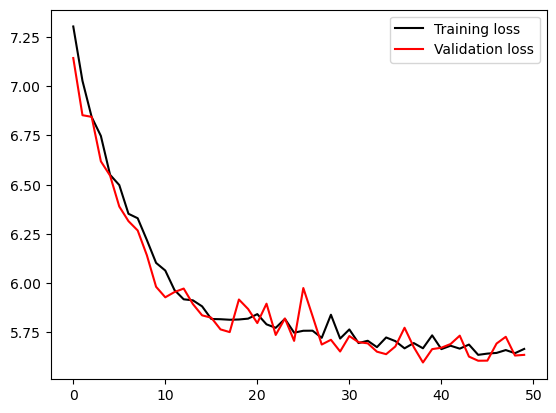

In [12]:
fig, ax = plt.subplots()

ax.plot(list(range(len(training_loss_list))), training_loss_list, color = 'black', label='Training loss')
ax.plot(list(range(len(validation_loss_list))), validation_loss_list,  color = 'red', label='Validation loss')
ax.legend()

## Show predictions
The output of a fully Bayesian NN is complex to understand / plot due to: 1) Bayesian layers provide predictions that are sampled from the corresponding distribution and therefore random.
2) Each prediction provides both a mean and a standard deviation.

The easiest way is to plot the training data set against the predictions using the Frozen_forward method. The network will then produce outputs with weights equal to the means. Each prediction is therefore deterministic (and has a mean and an std, which approximates aleatoric uncertainty). This is similar to defining a multi-head ANN.

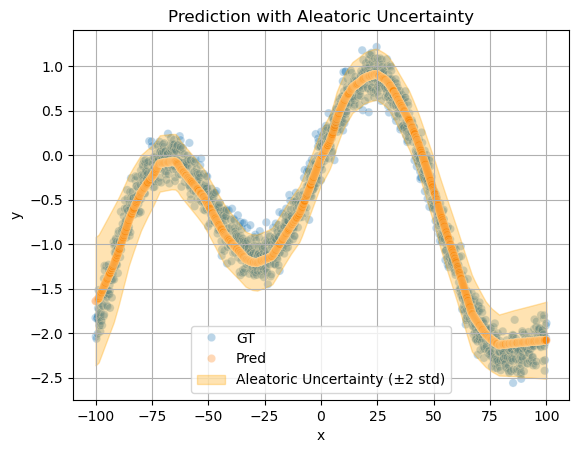

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the dataframe 
x_plot = np.array(training_df["x_range"])  # Input
y_plot = np.array(training_df["y_range"])  # GT
combined_predictions = [model.Frozen_forward(torch.tensor(i).view(1).to(device).float().unsqueeze(1)).to('cpu') for i in x_plot]
prediction_plot = [float(i[0][0]) for i in combined_predictions]
std_plot = [float(i[0][1]) for i in combined_predictions]

df_plot_train = pd.DataFrame({
    "x": np.append(x_plot, x_plot),
    "y": np.append(y_plot, prediction_plot),
    "GT/Pred": np.append(["GT"]*len(y_plot), ["Pred"]*len(prediction_plot))
})

# Scatter plot
sns.scatterplot(data=df_plot_train, x="x", y="y", hue="GT/Pred", alpha=0.3)

# Create the prediction bounds for the color zone (±2 std)
lower_bound = np.array(prediction_plot) - 2 * np.array(std_plot)
upper_bound = np.array(prediction_plot) + 2 * np.array(std_plot)

# Add the shaded region between lower_bound and upper_bound
plt.fill_between(x_plot, lower_bound, upper_bound, color='orange', alpha=0.3, label="Aleatoric Uncertainty (±2 std)")

# Adding labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Prediction with Aleatoric Uncertainty')

# Show legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

Standard predictions can be obtained using Monte Carlo predictions:
1) Point estimate is the mean of the mean predictions
2) Epistemic Uncertainty is related to the std of mean predictions
3) Aleatoric Uncertainty is related to the mean of std predictions

We report epistemic uncertainty as 3 std and aleatoric as 2 std (to magnify the effect of epistemic uncertainty). 

The number of MC simulation (n_iter) is set to a high value (100) to produce smooth plots.

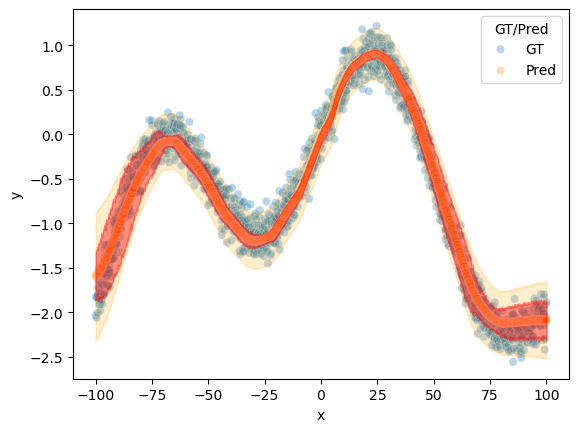

In [20]:
# Define the dataframe 
x_plot = np.array(training_df["x_range"])  # Input
y_plot = np.array(training_df["y_range"])  # GT

with torch.no_grad():
    combined_predictions = [model.MC_forward(torch.tensor(i).view(1).to(device).float().unsqueeze(1), n_iter = 200) for i in x_plot]
    
mean_predictions_mean = [float(i[0].to('cpu')) for i in combined_predictions]
std_predictions_mean = [float(i[1].to('cpu')) for i in combined_predictions]
mean_predictions_std = [float(i[2].to('cpu')) for i in combined_predictions]

# Create a DataFrame for plotting
df_plot_train = pd.DataFrame({
    "x": np.append(x_plot, x_plot),
    "y": np.append(y_plot, mean_predictions_mean),
    "GT/Pred": np.append(["GT"] * len(y_plot), ["Pred"] * len(prediction_plot))
})


# Scatter plot
sns.scatterplot(data=df_plot_train, x="x", y="y", hue="GT/Pred", alpha=0.3)

# Add the Aleatoric Uncertainty
lower_bound = np.array(mean_predictions_mean) - 2 * np.array(mean_predictions_std)
upper_bound = np.array(mean_predictions_mean) + 2 * np.array(mean_predictions_std)
plt.fill_between(x_plot, lower_bound, upper_bound, color='orange', alpha=0.2, label="Aleatoric Uncertainty (±2 std)")

# Add the Epistemic Uncertainty
lower_bound = np.array(mean_predictions_mean) - 3 * np.array(std_predictions_mean)
upper_bound = np.array(mean_predictions_mean) + 3 * np.array(std_predictions_mean)
plt.fill_between(x_plot, lower_bound, upper_bound, color='red', alpha=0.4, label="Epistemic Uncertainty (±3 std)")

Epistemic and aleatoric uncertainty can be added to provide the full uncertainty.

It should be noted that epistemic uncertainty is focues around the boundaries of the domain whereas aleatoric uncertainty follows the noise distribution (which is, in this example, homoscedastic).

In summary, given a point:

In [15]:
# Select the test point
x_prova = x_plot[1500]

# Evaluation mode
model.eval()

with torch.no_grad():
    # One (stochastic) forward pass
    print("\n Standard forward: ")
    output = model(torch.tensor(x_prova).view(1).to(device).float().unsqueeze(1))
    print("Mean:", output[0,0].to('cpu'))
    print("Std:", output[0,1].to('cpu'))    
    
    # One average Monte Carlo forward pass obtained by applying n_iter times the (stochastic) forward pass
    print("\n MC_forward: ")
    output = model.MC_forward(torch.tensor(x_prova).view(1).to(device).float().unsqueeze(1), n_iter=2000)
    print("Point estimate:", float(output[0].to('cpu')))
    print("Epistemic uncertainty:", float(output[1].to('cpu')))    
    print("Aleatoric uncertainty:", float(output[2].to('cpu')))    
    
    # One (determistic) forward pass using the average weights
    print("\n Frozen forward: ")
    output = model.Frozen_forward(torch.tensor(x_prova).view(1).to(device).float().unsqueeze(1))
    print("Mean:", output[0,0].to('cpu'))
    print("Std:", output[0,1].to('cpu'))


 Standard forward: 
Mean: tensor(-2.0209)
Std: tensor(0.1871)

 MC_forward: 
Point estimate: -2.106177806854248
Epistemic uncertainty: 0.06554160267114639
Aleatoric uncertainty: 0.19002076983451843

 Frozen forward: 
Mean: tensor(-2.1075)
Std: tensor(0.1901)
